# *Лабораторная работа №2*

## Построение регрессора для предсказания непрерывной величины (Теоретическая часть)

В данной лабораторной работе будет рассматриваться построение регрессионной модели для предсказания непрерывной величины.

In [ ]:
import pandas as pd
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

KeyboardInterrupt: 

Для примера построения регрессионной модели возьмем датасет, работу по очистке которого мы производили в рамках первой лекции (https://colab.research.google.com/drive/1fl7f7-8WA5GIjZ6qghfiD_2sEaCc1DQH?usp=sharing).

In [ ]:
%%capture
!wget https://www.dropbox.com/s/s1sqfsi6x7hbs28/autos_mod.csv

In [ ]:
df = pd.read_csv('autos_mod.csv', encoding='iso-8859-1')

In [ ]:
df.sample(10)

Удалим лишний столбец, возникший в результате записи датасета в файл. Кроме того, очистим базу от пустых значений, так как не все регрессионные методы могут обрабатывать поврежденные данные.

In [ ]:
del df['Unnamed: 0']
df_wo_na = df.dropna()
df_wo_na.reset_index(inplace=True)
del df_wo_na['index']

Проверим, что остались только необходимые нам столбцы.

In [ ]:
df_wo_na.sample(10)

Проведем факторизацию в столбцах со строковыми значениями. Для этого выпишем имена всех объектных столбцов и в цикле будем вызывать factorize из библиотеки pandas. [0] в конце строки с командой необходим так как factorize возвращает два набора значений - преобразованный столбец значений и упорядоченный список меток. Так как проводить операцию обратную факторизации мы не собираемся, то и второй столбец для нас не представляет интереса.

In [ ]:
column_names = ['vehicleType', 'gearbox', 'model', 'fuelType', 'brand', 'notRepairedDamage']
for i in column_names:
  df_wo_na[i] = pd.factorize(df_wo_na[i])[0]

Разобьем выборку на тренировочный и тестовый наборы.

In [ ]:
Y = df_wo_na['price']
X = df_wo_na.drop(['price'], axis = 1)
train_points, test_points, train_values, test_values = train_test_split(X, Y, test_size = 0.2)

Обучим модель случайного леса из 100 решающих деревьев.

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(train_points, train_values)

Оценку эффективности нашей модели проведем через расчет MAE. MAE (Mean Absolute Error) - средняя абсолютная ошибка, рассчитанная как сумма абсолютных ошибок в каждом предсказании, деленная на общий размер выборки.

In [ ]:
rf_predict = rf_model.predict(test_points)
print(mean_absolute_error(test_values, rf_predict))

Разброс предсказнной цены в $5000+ не вызывает особого восторга. Попробуем произвести обучение других моделей и сравним результаты.

In [ ]:
nn_model = Sequential()
nn_model.add(Dense(9, activation='relu'))
nn_model.add(Dense(15, activation='relu'))
nn_model.add(Dense(15, activation='relu'))
nn_model.add(Dense(1, activation='linear'))

nn_model.compile(loss='mean_absolute_error', optimizer='adam')

results = nn_model.fit(
 train_points, train_values,
 epochs= 10,
 batch_size = 1000,
 validation_data = (test_points, test_values)
)

Значение функции потерь при обучении нейронной сети является MAE оценкой. Получили сопоставимый со случайным лесом результат.

Напоследок, построим регрессор через градиентный бустинг.

In [ ]:
import xgboost as xgb
xg_reg = xgb.XGBRegressor(objective = 'reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)

In [ ]:
xg_reg.fit(train_points, train_values)

In [ ]:
xgb_predict = xg_reg.predict(test_points)

Оценим качество получившейся модели.

In [ ]:
print(mean_absolute_error(test_values, xgb_predict))

Градиентный бустинг показал результаты еще хуже, чем были до этого... Попробуем проанализировать причины такого поведения.

Выведем график соответствия предсказанной и фактической цены.

In [ ]:
plt.figure(figsize=(7, 7))
plt.scatter(test_values, xgb_predict) # рисуем точки, соответствущие парам настоящее значение - прогноз
plt.plot([0, max(test_values)], [0, max(xgb_predict)]) # рисуем прямую, на которой предсказания и настоящие значения совпадают
plt.xlabel('Настоящая цена', fontsize=20)
plt.ylabel('Предсказанная цена', fontsize=20);

Благодаря графическому представлению мы обнаружили сильнейшие вылеты максимальной цены автомобилей. Произведем анализ данного столбца.

In [ ]:
df_wo_na.hist(["price"])

На гистограмме видно, что у нас есть экземпляры, цена на которые доходит до 100 миллиардов. Произведем отбор записей по цене, исключив также записи со слишком низкой ценой.

In [ ]:
df_wo_na = df_wo_na[(df_wo_na['price'] < 20000) & (df_wo_na['price'] > 50)]
df_wo_na.reset_index(inplace=True)
del df_wo_na['index']

Выведем гисторгамму для распределения цен на автомобили после внесенных нами изменений.

In [ ]:
df_wo_na.hist(["price"])

Вновь проведем разделение на тренировочную и тестовую выборки.

In [ ]:
Y = df_wo_na['price']
X = df_wo_na.drop(['price'], axis = 1)
train_points, test_points, train_values, test_values = train_test_split(X, Y, test_size = 0.2)

Создадим модель градиентного бустинга на основе обновленных данных.

In [ ]:
xg_reg.fit(train_points, train_values)

In [ ]:
xgb_predict = xg_reg.predict(test_points)

In [ ]:
print(mean_absolute_error(test_values, xgb_predict))

Получившийся результат гораздо лучше с точки зрения отклонения абсолютной ошибки. Выведем график, чтобы оценить произошедшие изменения.

In [ ]:
plt.figure(figsize=(7, 7))
plt.scatter(test_values, xgb_predict) # рисуем точки, соответствущие парам настоящее значение - прогноз
plt.plot([0, max(test_values)], [0, max(xgb_predict)]) # рисуем прямую, на которой предсказания и настоящие значения совпадают
plt.xlabel('Настоящая цена', fontsize=20)
plt.ylabel('Предсказанная цена', fontsize=20);

На графике явно видно, что наша модель показывает гораздо худшие резуьтаты для автомобилей с низкой стоимостью. Запомним этот факт и попробуем собрать модель на основе случайного леса, так как до проведения фильтрации по цене градиентный бустинг показывал худшие результаты.

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(train_points, train_values)
rf_predict = rf_model.predict(test_points)

In [ ]:
print(mean_absolute_error(test_values, rf_predict))

Средняя абсолютная ошибка меньше для модели случайного леса почти на $300, что является серьезным аргументом в ее пользу. Выведем график с отклонениями.

In [ ]:
plt.figure(figsize=(7, 7))
plt.scatter(test_values, rf_predict) # рисуем точки, соответствущие парам настоящее значение - прогноз
plt.plot([0, max(test_values)], [0, max(rf_predict)]) # рисуем прямую, на которой предсказания и настоящие значения совпадают
plt.xlabel('Настоящая цена', fontsize=20)
plt.ylabel('Предсказанная цена', fontsize=20);

Теперь давайте разберемся в причинах того, что градиентный бустинг показывает результаты гораздо хуже случайного леса. Разгадка кроется в типах ансамблевых методов, которые лежат в основе данных моделей.

Случайный лес работает на основе бэггинга, то есть собирает ансамбль из слабых учеников, каждый из которых имеет собственный независимый набор данных и, как следствие, свой набор правил разделения записей. После получения решения от всех учеников принимается некое усредненное значение.

Градиентный бустинг же направлен на исправление результата самого слабого ученика. Это приводит к тому, что итоговая модель будет смещаться в направлении самых больших вылетов, что мы и видели на графиках выше.

Можно сделать вывод, что механизм градиентного бустинга наилучшим образом подходит для решения задач со взвешенным набором данных, т.е. с (примерно) равным количеством записей, относящихся к каждому классу, либо диапазону значений.

Проведем исследование также для нейросетевой модели.

In [ ]:
nn_model = Sequential()
nn_model.add(Dense(9, activation='relu'))
nn_model.add(Dense(15, activation='relu'))
nn_model.add(Dense(15, activation='relu'))
nn_model.add(Dense(1))

nn_model.compile(loss='mean_absolute_error', optimizer='adam')

results = nn_model.fit(
 train_points, train_values,
 epochs= 10,
 batch_size = 100,
 validation_data = (test_points, test_values)
)

nn_predict = nn_model.predict(test_points)
print(mean_absolute_error(test_values, nn_predict))

Теперь лидером нашего антирейтинга результатов стала модель, основанная на нейронных сетях.

Попробуем провести нормализацию данных и сранить результаты.

In [ ]:
df_norm = df_wo_na
Y = df_norm['price']
X = df_norm.drop(['price'], axis = 1)
for i in X.columns:
  X[i]=(X[i]-X[i].min())/(X[i].max()-X[i].min())

In [ ]:
X

In [ ]:
Y

In [ ]:
train_points, test_points, train_values, test_values = train_test_split(X, Y, test_size = 0.2)

In [ ]:
xg_reg.fit(train_points, train_values)

In [ ]:
xgb_predict = xg_reg.predict(test_points)

In [ ]:
print(mean_absolute_error(test_values, xgb_predict))

Положительная динамика в модели градиентного бустинга прослеживается, но она явно не претендует на роль ключевого фактора.

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(train_points, train_values)
rf_predict = rf_model.predict(test_points)

In [ ]:
print(mean_absolute_error(test_values, rf_predict))

А вот для случайного леса нормализация сыграла даже немного отрицательную роль. Связано это с тем, что при построении правил решающему дереву гораздо проще ориентироваться на натуральные числа, нежели на диапазон [0, 1].

In [ ]:
nn_model = Sequential()
nn_model.add(Dense(9, activation='relu'))
nn_model.add(Dense(15, activation='relu'))
nn_model.add(Dense(15, activation='relu'))
nn_model.add(Dense(1))

nn_model.compile(loss='mean_absolute_error', optimizer='adam')

results = nn_model.fit(
 train_points, train_values,
 epochs= 10,
 batch_size = 100,
 validation_data = (test_points, test_values)
)

nn_predict = nn_model.predict(test_points)
print(mean_absolute_error(test_values, nn_predict))

Для нейросетевой модели нормализация значительно облегчила задачу, но приблизиться к точности ансамблевых методов мы так и не смогли.

Рассмотрим популярность различных признаков при принятии решения в модели градиентного бустинга и попробуем удалить наиболее непопулярные.

In [ ]:
xgb.plot_importance(xg_reg)
plt.show()

In [ ]:
del df_wo_na['notRepairedDamage']
del df_wo_na['gearbox']
train_points, test_points, train_values, test_values = train_test_split(X, Y, test_size = 0.2)

Проверим влияние внесенных изменений на качество наших моделей.

In [ ]:
nn_model = Sequential()
nn_model.add(Dense(7, activation='relu'))
nn_model.add(Dense(15, activation='relu'))
nn_model.add(Dense(15, activation='relu'))
nn_model.add(Dense(1))

nn_model.compile(loss='mean_absolute_error', optimizer='adam')

results = nn_model.fit(
 train_points, train_values,
 epochs= 10,
 batch_size = 100,
 validation_data = (test_points, test_values)
)

nn_predict = nn_model.predict(test_points)
print(mean_absolute_error(test_values, nn_predict))

Точность нейросетевой модели, хоть и незначительно, но упала.

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(train_points, train_values)
rf_predict = rf_model.predict(test_points)

In [ ]:
print(mean_absolute_error(test_values, rf_predict))

In [ ]:
xg_reg.fit(train_points, train_values)
xgb_predict = xg_reg.predict(test_points)
print(mean_absolute_error(test_values, xgb_predict))

А вот ансамблевые методы показали небольшой рост точности.

Ну и напоследок проверим, каким образом скажется на качестве моделей разделение столбцов по способу факторизации.

In [ ]:
df_wo_na = df.dropna()
df_wo_na.reset_index(inplace=True)
del df_wo_na['index']

Для столбцов с высокой кардинальностью оставим стандартный алгоритм, а для столбцов с низкой применим OneHotEncoding.

In [ ]:
column_names_fact = ['vehicleType', 'model','brand']
column_names_dummies = ['gearbox', 'fuelType', 'notRepairedDamage']
for i in column_names_fact:
  df_wo_na[i] = pd.factorize(df_wo_na[i])[0]
df_wo_na = pd.get_dummies(df_wo_na, prefix=column_names_dummies)

In [ ]:
df_wo_na = df_wo_na[(df_wo_na['price'] < 20000) & (df_wo_na['price'] > 50)]
df_wo_na.reset_index(inplace=True)
del df_wo_na['index']

In [ ]:
Y = df_wo_na['price']
X = df_wo_na.drop(['price'], axis = 1)

In [ ]:
train_points, test_points, train_values, test_values = train_test_split(X, Y, test_size = 0.2)

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(train_points, train_values)
rf_predict = rf_model.predict(test_points)

In [ ]:
print(mean_absolute_error(test_values, rf_predict))

Модель случайного леса осталась равнодушна к увеличению количества столбцов.

In [ ]:
xg_reg.fit(train_points, train_values)
xgb_predict = xg_reg.predict(test_points)
print(mean_absolute_error(test_values, xgb_predict))

А вот градиентный бустинг значительно улучшил точность предсказываемой цены.

In [ ]:
nn_model = Sequential()
nn_model.add(Dense(17, activation='relu'))
nn_model.add(Dense(15, activation='relu'))
nn_model.add(Dense(15, activation='relu'))
nn_model.add(Dense(1))

nn_model.compile(loss='mean_absolute_error', optimizer='adam')

results = nn_model.fit(
 train_points, train_values,
 epochs= 10,
 batch_size = 100,
 validation_data = (test_points, test_values)
)

nn_predict = nn_model.predict(test_points)
print(mean_absolute_error(test_values, nn_predict))

Нейронные сети продемонcтрировали ухудшение качества модели при увеличении объема входных данных.

Попробуем собрать еще модель линейной регрессии.

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(train_points, train_values)
lr_predict = model.predict(test_points)
print(mean_absolute_error(test_values, lr_predict))

Метрика MAE говорит, что модель линейной регрессии справляется с задачей лучше, чем нейронные сети. Проверим этот результат графически.

In [ ]:
plt.figure(figsize=(7, 7))
plt.scatter(test_values, lr_predict) # рисуем точки, соответствущие парам настоящее значение - прогноз
plt.plot([0, max(test_values)], [0, max(lr_predict)]) # рисуем прямую, на которой предсказания и настоящие значения совпадают
plt.xlabel('Настоящая цена', fontsize=20)
plt.ylabel('Предсказанная цена', fontsize=20);

Из-за излишней концентрации на вылетах модель линейной регрессии имеет тенденцию занижать цену для дорогих автомобилей. Связано это с тем, что наша выборка не является взвешенной, то есть имеет гораздо меньший объем записей об автомобилях с высокой ценой, чем с низкой.

## Построение регрессора для предсказания непрерывной величины (*Практическая* часть)

###Задание базового уровня

Вашим заданием в данной лабораторной будет построение регрессионной модели для предсказания цены квартиры для датасета, содержащего информацию о продаже недвижимости в Нью-Йорке.

https://www.kaggle.com/new-york-city/nyc-property-sales

###Задание повышенного уровня

Выполнить задание базового уровня. Методика оценки - **mean_absolute_error**. Ошибка для полученного решения должна быть ниже отметки **125000**.

Размер датасета после всех производимых манипуляций должен быть больше **50000** записей.


In [ ]:
%%capture
!wget https://www.dropbox.com/s/0un1sdvifenp2ir/nyc-rolling-sales.csv

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 4.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

df = pd.read_csv('nyc-rolling-sales.csv')
del df['Unnamed: 0']
df = df.dropna()
df.reset_index(inplace=True)
del df['index']
df

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,,...,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,,...,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,,...,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,,...,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,,...,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84543,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7349,34,,B9,37 QUAIL LANE,,...,2,0,2,2400,2575,1998,1,B9,450000,2016-11-28 00:00:00
84544,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7349,78,,B9,32 PHEASANT LANE,,...,2,0,2,2498,2377,1998,1,B9,550000,2017-04-21 00:00:00
84545,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7351,60,,B2,49 PITNEY AVENUE,,...,2,0,2,4000,1496,1925,1,B2,460000,2017-07-05 00:00:00
84546,5,WOODROW,22 STORE BUILDINGS,4,7100,28,,K6,2730 ARTHUR KILL ROAD,,...,0,7,7,208033,64117,2001,4,K6,11693337,2016-12-21 00:00:00


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   BOROUGH                         84548 non-null  int64 
 1   NEIGHBORHOOD                    84548 non-null  object
 2   BUILDING CLASS CATEGORY         84548 non-null  object
 3   TAX CLASS AT PRESENT            84548 non-null  object
 4   BLOCK                           84548 non-null  int64 
 5   LOT                             84548 non-null  int64 
 6   EASE-MENT                       84548 non-null  object
 7   BUILDING CLASS AT PRESENT       84548 non-null  object
 8   ADDRESS                         84548 non-null  object
 9   APARTMENT NUMBER                84548 non-null  object
 10  ZIP CODE                        84548 non-null  int64 
 11  RESIDENTIAL UNITS               84548 non-null  int64 
 12  COMMERCIAL UNITS                84548 non-null

In [ ]:
import numpy as np
df['SALE PRICE'] = df['SALE PRICE'].replace(' -  ', np.nan)
df['SALE PRICE'] = df['SALE PRICE'].astype('float64')
df = df.dropna()
df.reset_index(inplace=True)
del df['index']

In [ ]:
df

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,,...,5,0,5,1633,6440,1900,2,C2,6625000.0,2017-07-19 00:00:00
1,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,,...,10,0,10,2272,6794,1913,2,C4,3936272.0,2016-09-23 00:00:00
2,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,,...,6,0,6,2369,4615,1900,2,C2,8000000.0,2016-11-17 00:00:00
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,406,32,,C4,210 AVENUE B,,...,8,0,8,1750,4226,1920,2,C4,3192840.0,2016-09-23 00:00:00
4,1,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2,387,153,,D9,629 EAST 5TH STREET,,...,24,0,24,4489,18523,1920,2,D9,16232000.0,2016-11-07 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69982,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7349,34,,B9,37 QUAIL LANE,,...,2,0,2,2400,2575,1998,1,B9,450000.0,2016-11-28 00:00:00
69983,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7349,78,,B9,32 PHEASANT LANE,,...,2,0,2,2498,2377,1998,1,B9,550000.0,2017-04-21 00:00:00
69984,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7351,60,,B2,49 PITNEY AVENUE,,...,2,0,2,4000,1496,1925,1,B2,460000.0,2017-07-05 00:00:00
69985,5,WOODROW,22 STORE BUILDINGS,4,7100,28,,K6,2730 ARTHUR KILL ROAD,,...,0,7,7,208033,64117,2001,4,K6,11693337.0,2016-12-21 00:00:00


In [ ]:
# Числовые фичи без целевой переменной
num_cols = df.select_dtypes(include='number').columns.tolist()
num_cols.remove('SALE PRICE')

# Категориальные фичи
cat_cols = df.select_dtypes(include='object').columns.tolist()

# Целевая переменная
target_col = 'SALE PRICE'

In [ ]:
num_cols

['BOROUGH',
 'BLOCK',
 'LOT',
 'ZIP CODE',
 'RESIDENTIAL UNITS',
 'COMMERCIAL UNITS',
 'TOTAL UNITS',
 'YEAR BUILT',
 'TAX CLASS AT TIME OF SALE']

In [ ]:
cat_cols = df.select_dtypes(include='object').columns

for i in range(len(cat_cols)):
  print(cat_cols[i])
  print(pd.value_counts(df[cat_cols[i]]).shape[0])

NEIGHBORHOOD
254
BUILDING CLASS CATEGORY
47
TAX CLASS AT PRESENT
11
EASE-MENT
1
BUILDING CLASS AT PRESENT
161
ADDRESS
57304
APARTMENT NUMBER
3320
LAND SQUARE FEET
5293
GROSS SQUARE FEET
5095
BUILDING CLASS AT TIME OF SALE
161
SALE DATE
362


In [ ]:
for i in cat_cols:
  df[i] = pd.factorize(df[i])[0]

<ipython-input-24-506a33814697>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i] = pd.factorize(df[i])[0]
<ipython-input-24-506a33814697>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i] = pd.factorize(df[i])[0]
<ipython-input-24-506a33814697>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

array([[<Axes: title={'center': 'SALE PRICE'}>]], dtype=object)

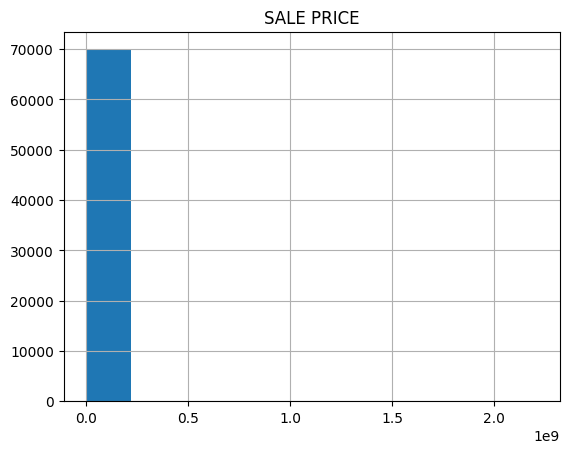

In [ ]:
df.hist(target_col)

In [ ]:
lim = np.abs((df[num_cols] - df[num_cols].mean()) / df[num_cols].std(ddof=0)) < 3
df[num_cols] = df[num_cols].where(lim, np.nan)
df.dropna(inplace=True)

<ipython-input-26-e5b8dedea087>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_cols] = df[num_cols].where(lim, np.nan)
<ipython-input-26-e5b8dedea087>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [ ]:
df = df[(df[target_col] < 6000000) & (df[target_col] > 50)]
df.reset_index(inplace=True)
del df['index']

df = df[(df['YEAR BUILT'] > 1880)]
df.reset_index(inplace=True)
del df['index']

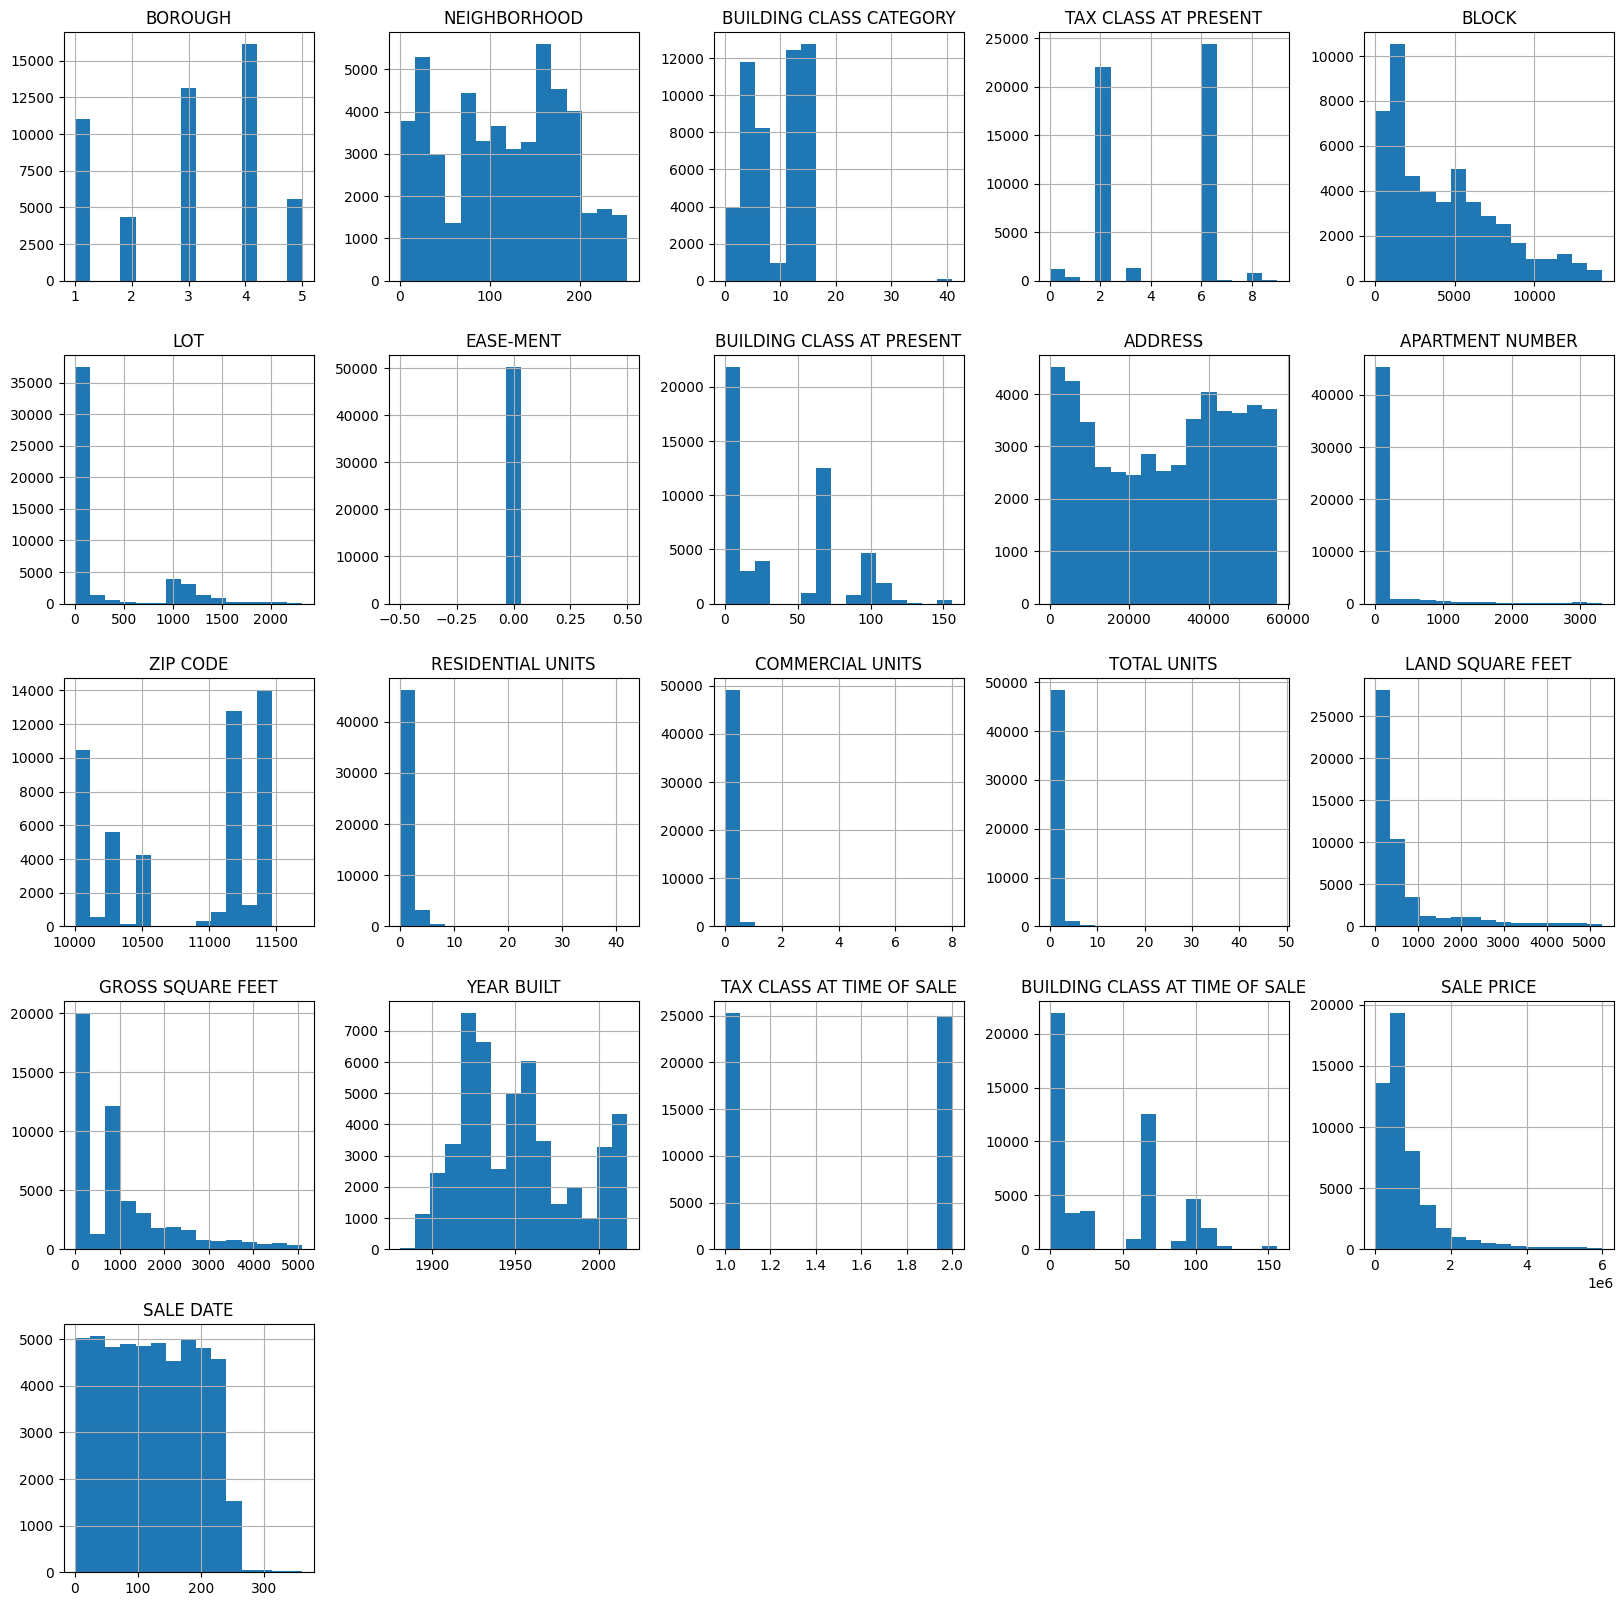

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
df.hist( figsize=[20, 20], bins=15)
plt.show()

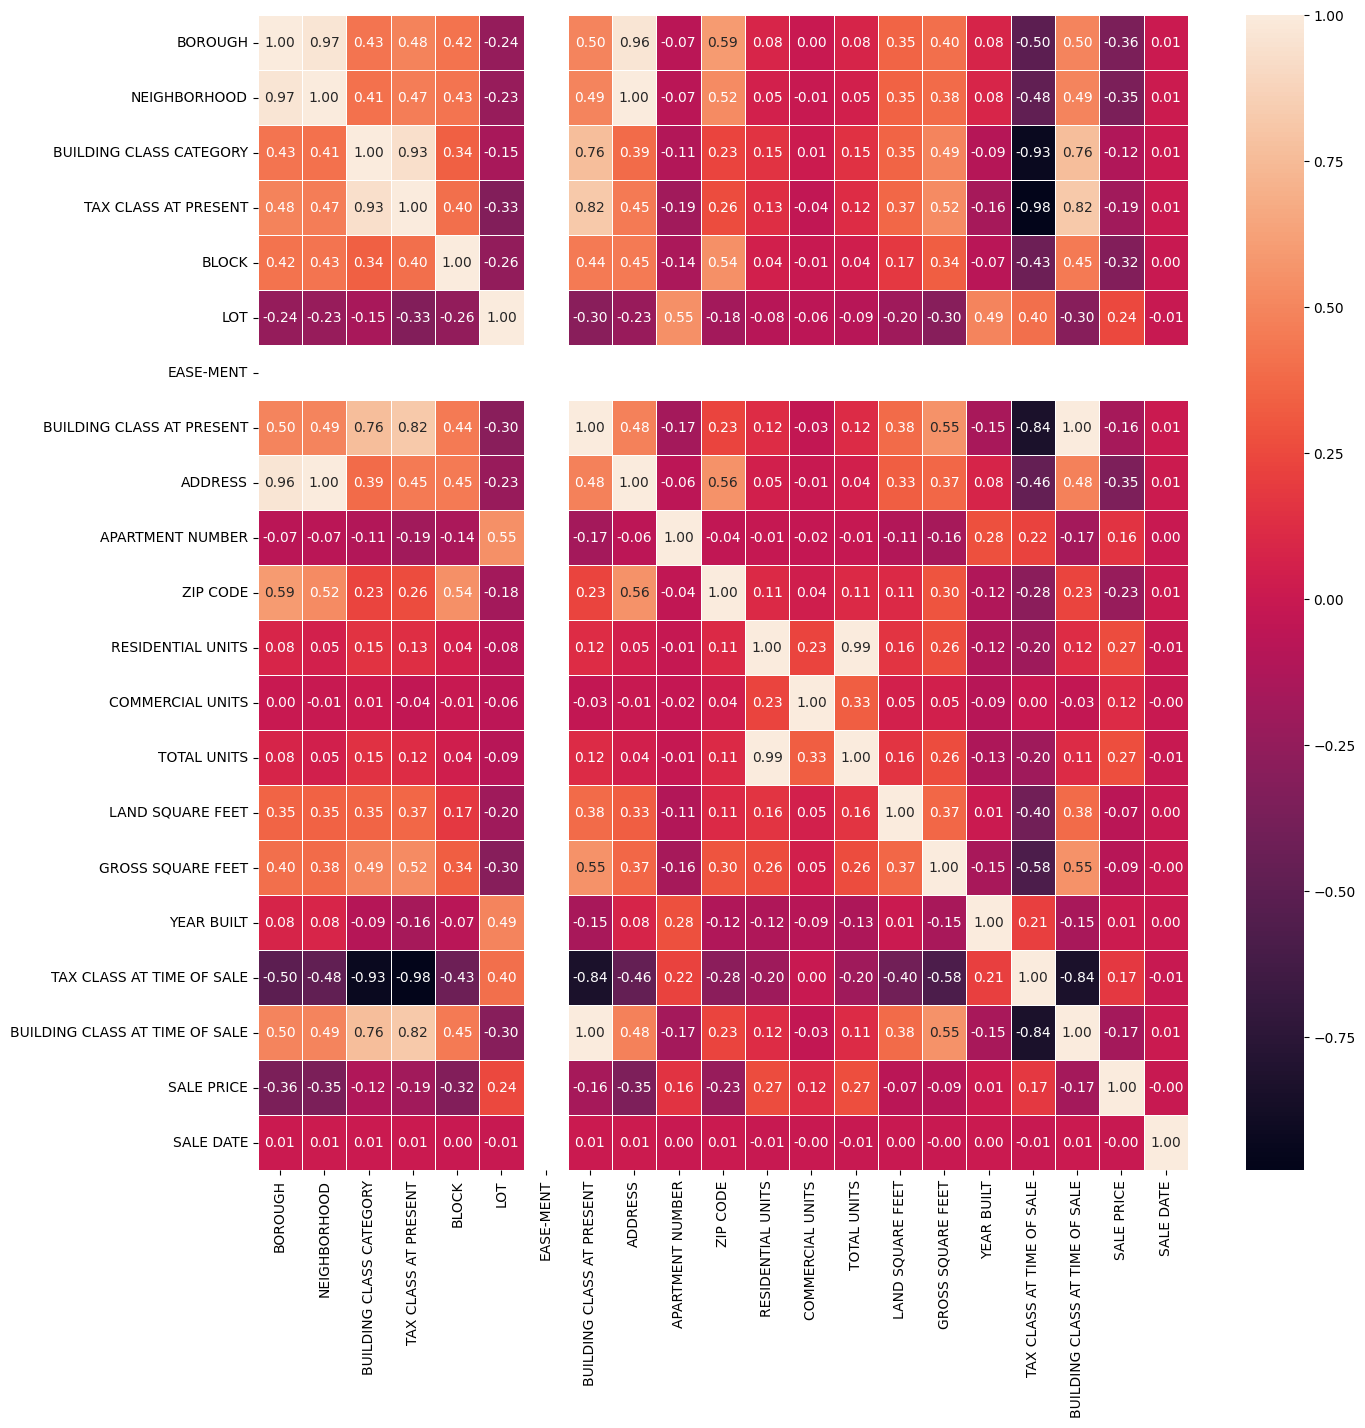

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(method = 'pearson'),annot=True,fmt=".2f", linewidth=.5)
plt.show()

In [ ]:
df.drop(['EASE-MENT', 'ADDRESS', 'BUILDING CLASS AT PRESENT', 'BUILDING CLASS CATEGORY', 'TAX CLASS AT PRESENT', 'SALE DATE'], axis=1, inplace=True)

In [ ]:
df

,BOROUGH,NEIGHBORHOOD,BLOCK,LOT,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE
0,1,0,402.0,21.0,0,10009.0,10.0,0.0,10.0,1,1,1913.0,2.0,1,3936272.0
1,1,0,406.0,32.0,0,10009.0,8.0,0.0,8.0,3,3,1920.0,2.0,1,3192840.0
2,1,0,373.0,40.0,0,10009.0,0.0,0.0,0.0,6,6,1920.0,2.0,4,499000.0
3,1,0,373.0,40.0,0,10009.0,0.0,0.0,0.0,6,6,1920.0,2.0,4,529500.0
4,1,0,373.0,40.0,0,10009.0,0.0,0.0,0.0,6,6,1920.0,2.0,4,423000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50214,5,253,7316.0,93.0,0,10309.0,2.0,0.0,2.0,758,1723,1995.0,1.0,69,509000.0
50215,5,253,7317.0,126.0,0,10309.0,2.0,0.0,2.0,5290,177,1994.0,1.0,69,648000.0
50216,5,253,7349.0,34.0,0,10309.0,2.0,0.0,2.0,259,4265,1998.0,1.0,55,450000.0
50217,5,253,7349.0,78.0,0,10309.0,2.0,0.0,2.0,190,5091,1998.0,1.0,55,550000.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50219 entries, 0 to 50218
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   BOROUGH                         50219 non-null  int64  
 1   NEIGHBORHOOD                    50219 non-null  int64  
 2   BLOCK                           50219 non-null  float64
 3   LOT                             50219 non-null  float64
 4   APARTMENT NUMBER                50219 non-null  int64  
 5   ZIP CODE                        50219 non-null  float64
 6   RESIDENTIAL UNITS               50219 non-null  float64
 7   COMMERCIAL UNITS                50219 non-null  float64
 8   TOTAL UNITS                     50219 non-null  float64
 9   LAND SQUARE FEET                50219 non-null  int64  
 10  GROSS SQUARE FEET               50219 non-null  int64  
 11  YEAR BUILT                      50219 non-null  float64
 12  TAX CLASS AT TIME OF SALE       

In [ ]:
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Все фичи
feature_cols =  df.columns.tolist()
feature_cols.remove('SALE PRICE')

x_train, x_test, y_train, y_test = train_test_split(df[feature_cols], df[target_col], test_size=0.2)

In [ ]:
rf_model = ensemble.RandomForestRegressor(n_estimators=30)
rf_model.fit(x_train, y_train)
test_predict_rf = rf_model.predict(x_test)
print(mean_absolute_error(y_test, test_predict_rf))
mean_squared_error(y_true=y_test, y_pred=test_predict_rf)
# 262784
# 247601519007

262151.17513189244


240781359627.30402

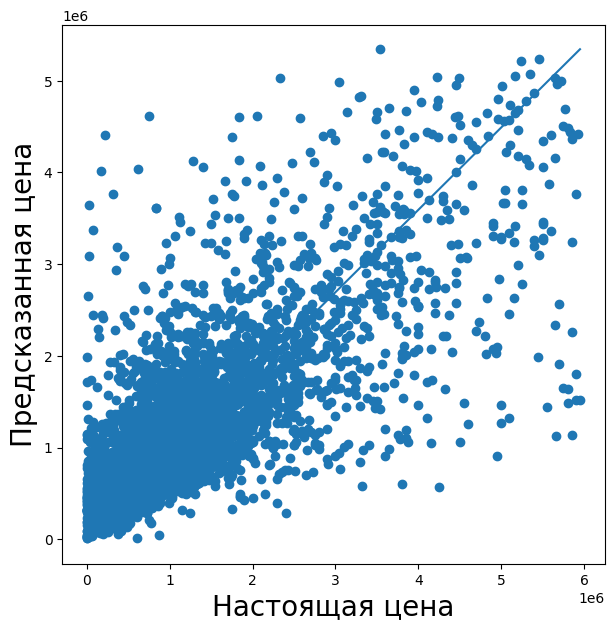

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 7))
plt.scatter(y_test, test_predict_rf) # рисуем точки, соответствущие парам настоящее значение - прогноз
plt.plot([0, max(y_test)], [0, max(test_predict_rf)]) # рисуем прямую, на которой предсказания и настоящие значения совпадают
plt.xlabel('Настоящая цена', fontsize=20)
plt.ylabel('Предсказанная цена', fontsize=20);

In [ ]:
import xgboost as xgb
xg_reg = xgb.XGBRegressor(objective = 'reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)
xg_reg.fit(x_train, y_train)
xgb_predict = xg_reg.predict(x_test)
print(mean_absolute_error(y_test, xgb_predict))

305410.6352198763


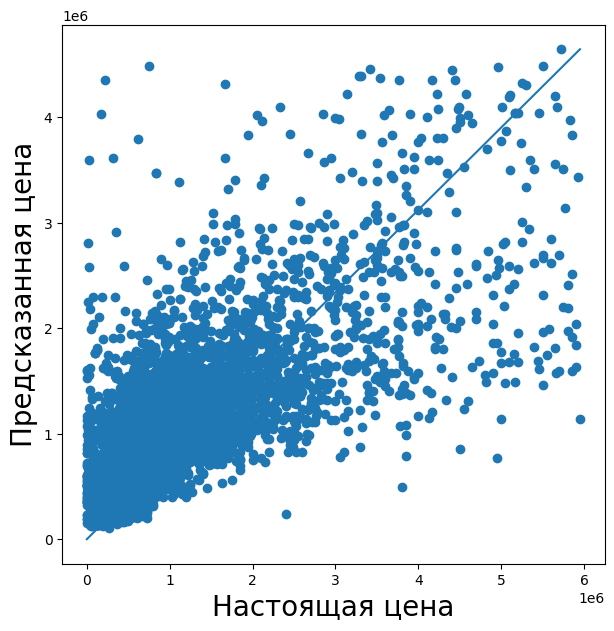

In [ ]:
plt.figure(figsize=(7, 7))
plt.scatter(y_test, xgb_predict) # рисуем точки, соответствущие парам настоящее значение - прогноз
plt.plot([0, max(y_test)], [0, max(xgb_predict)]) # рисуем прямую, на которой предсказания и настоящие значения совпадают
plt.xlabel('Настоящая цена', fontsize=20)
plt.ylabel('Предсказанная цена', fontsize=20);

In [ ]:
from catboost import CatBoostRegressor
model = CatBoostRegressor(
    iterations=100, depth=6, learning_rate=0.1, verbose=False)
model.fit(x_train, y_train)
y_pred_cbt=model.predict(x_test)
print(mean_absolute_error(y_true=y_test, y_pred=y_pred_cbt))

318587.18807958544


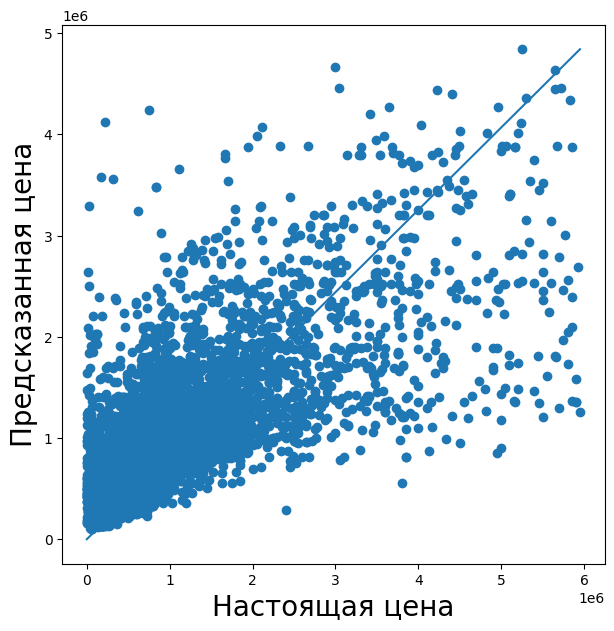

In [ ]:
plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_pred_cbt) # рисуем точки, соответствущие парам настоящее значение - прогноз
plt.plot([0, max(y_test)], [0, max(y_pred_cbt)]) # рисуем прямую, на которой предсказания и настоящие значения совпадают
plt.xlabel('Настоящая цена', fontsize=20)
plt.ylabel('Предсказанная цена', fontsize=20);